In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd

#Load excel file into pandas dataframe
rawData = pd.read_excel("/content/drive/MyDrive/CSE_oil_sample_data.xlsx")
rawData.head()
pd.isnull(rawData).sum()

ID                    0
Asset                 0
Phase                 3
Damage_flag          14
Hydrogen              7
Oxygen                7
Nitrogen              7
Carbon_dioxide        7
Carbon_monoxide       7
Methane               1
Ethylene              1
Ethane                1
Acetylene             1
Moisture              1
Breakdown_voltage     3
age                  34
Year_Installed        1
Year_sampled          0
Type                  0
dtype: int64

In [ ]:
#Remove ID column
rawData.drop("ID", axis=1 ,inplace=True)

In [ ]:
#Check datatypes of columns
rawData.dtypes

Asset                 object
Phase                 object
Damage_flag          float64
Hydrogen             float64
Oxygen               float64
Nitrogen             float64
Carbon_dioxide       float64
Carbon_monoxide      float64
Methane              float64
Ethylene             float64
Ethane               float64
Acetylene            float64
Moisture             float64
Breakdown_voltage    float64
age                  float64
Year_Installed       float64
Year_sampled           int64
Type                  object
dtype: object

In [ ]:
#Encode asset, phase and type columns

#Convert the type of each of these columns to "category"
rawData["Asset"] = rawData["Asset"].astype("category")
rawData["Phase"] = rawData["Phase"].astype("category")
rawData["Type"] = rawData["Type"].astype("category")

#Create a new column with the category code of each value in the original column
rawData["Asset_cat"] = rawData["Asset"].cat.codes
rawData["Phase_cat"] = rawData["Phase"].cat.codes
rawData["Type_cat"] = rawData["Type"].cat.codes

#Drop original columns
rawData.drop(["Asset", "Phase", "Type"], axis=1, inplace=True)

rawData.head()

,Damage_flag,Hydrogen,Oxygen,Nitrogen,Carbon_dioxide,Carbon_monoxide,Methane,Ethylene,Ethane,Acetylene,Moisture,Breakdown_voltage,age,Year_Installed,Year_sampled,Asset_cat,Phase_cat,Type_cat
0,0.0,490.0,20523.0,83124.0,918.0,706.0,11237.0,1084.0,261.0,37.0,93.0,15.0,18.0,1998.0,2016,0,1,0
1,0.0,390.0,18992.0,79930.0,1812.0,968.0,11116.0,226.0,283.0,33.0,102.0,16.0,18.0,1998.0,2016,0,3,0
2,0.0,611.0,19456.0,66956.0,1245.0,605.0,9933.0,412.0,300.0,35.0,110.0,19.0,18.0,1998.0,2016,0,0,0
3,1.0,159.0,22303.0,73486.0,652.0,224.0,4183.0,143.0,129.0,1.7,93.0,22.0,18.0,1998.0,2016,1,0,0
4,NaN,168.0,23950.0,85464.0,687.0,262.0,4107.0,157.0,120.0,1.7,94.0,29.0,18.0,1998.0,2016,1,3,0


In [ ]:
#Check summary statistics of data
rawData.describe()

,Damage_flag,Hydrogen,Oxygen,Nitrogen,Carbon_dioxide,Carbon_monoxide,Methane,Ethylene,Ethane,Acetylene,Moisture,Breakdown_voltage,age,Year_Installed,Year_sampled,Asset_cat,Phase_cat,Type_cat
count,85.000000,92.000000,92.000000,92.000000,92.000000,92.000000,98.000000,98.000000,98.000000,98.000000,98.000000,96.000000,65.000000,98.000000,99.000000,99.000000,99.000000,99.000000
mean,0.129412,138.009783,29470.304348,70155.293478,1258.819565,296.169565,17878.989796,86.282653,348.838776,7.964286,73.826531,40.616667,12.600000,1959.030612,16091.282828,17.272727,1.232323,1.616162
std,0.337647,274.490332,59384.074738,26773.637560,1776.669961,198.071624,20587.984582,136.675773,266.508580,26.655679,28.871927,17.002536,5.246427,284.287986,19560.226491,10.677860,1.300143,1.496302
min,0.000000,0.000000,1700.000000,18000.000000,1.400000,0.600000,1.000000,0.100000,0.100000,0.000000,12.000000,11.000000,0.000000,0.000000,2016.000000,0.000000,-1.000000,0.000000
25%,0.000000,12.750000,9250.000000,50000.000000,505.000000,163.750000,2440.250000,6.000000,135.750000,0.000000,50.250000,25.000000,8.000000,1996.000000,2016.000000,8.500000,0.000000,0.000000
50%,0.000000,44.000000,21027.000000,79965.000000,804.500000,261.000000,7660.000000,33.000000,270.000000,0.100000,77.000000,38.500000,13.000000,2001.500000,2017.000000,17.000000,1.000000,2.000000
75%,0.000000,152.250000,34819.250000,89412.250000,1373.500000,390.000000,33500.000000,119.750000,577.500000,4.025000,90.750000,53.000000,15.000000,2003.000000,43013.000000,27.000000,3.000000,3.000000
max,1.000000,2200.000000,503341.000000,133180.000000,12659.000000,968.000000,85000.000000,1084.000000,1100.000000,222.000000,182.000000,97.000000,21.000000,2011.000000,43164.000000,35.000000,3.000000,5.000000


In [ ]:
#Set erroneous sample years to the median (some of the years are ridiculously large)

rawData["Year_sampled"].loc[(rawData["Year_sampled"] > 2018)] = rawData["Year_sampled"].median()
rawData["Year_sampled"].describe()

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


count      99.000000
mean     2016.595960
std         0.551791
min      2016.000000
25%      2016.000000
50%      2017.000000
75%      2017.000000
max      2018.000000
Name: Year_sampled, dtype: float64

In [ ]:
#Check number of missing values
pd.isnull(rawData).sum()

Damage_flag          14
Hydrogen              7
Oxygen                7
Nitrogen              7
Carbon_dioxide        7
Carbon_monoxide       7
Methane               1
Ethylene              1
Ethane                1
Acetylene             1
Moisture              1
Breakdown_voltage     3
age                  34
Year_Installed        1
Year_sampled          0
Asset_cat             0
Phase_cat             0
Type_cat              0
dtype: int64

In [ ]:
#Replace other missing values with the columns mean, except for the damage flag and age columns
damageFlag = rawData["Damage_flag"].copy()
age = rawData["age"].copy()
rawDataCopy = rawData.drop(["Damage_flag", "age"], axis=1)
rawDataCopy.fillna(rawData.mean(), inplace=True)
rawDataCopy["Damage_flag"] = damageFlag
rawDataCopy["age"] = age
pd.isnull(rawDataCopy).sum()

Hydrogen              0
Oxygen                0
Nitrogen              0
Carbon_dioxide        0
Carbon_monoxide       0
Methane               0
Ethylene              0
Ethane                0
Acetylene             0
Moisture              0
Breakdown_voltage     0
Year_Installed        0
Year_sampled          0
Asset_cat             0
Phase_cat             0
Type_cat              0
Damage_flag          14
age                  34
dtype: int64

In [ ]:
#Replace missing ages with the difference between the year sampled and year installed

rawDataCopy["age"].fillna(rawDataCopy["Year_sampled"] - rawDataCopy["Year_Installed"], inplace=True)
pd.isnull(rawDataCopy["age"]).sum()

#Drop Year sampled and year installed columns after
rawDataCopy.drop(["Year_sampled", "Year_Installed"], axis=1, inplace=True)

In [ ]:
#Fill missing damage flag values using KNN predictions
from sklearn.neighbors import KNeighborsClassifier

x_preds = rawDataCopy[rawDataCopy["Damage_flag"].isnull()]
x_train = rawDataCopy[rawDataCopy["Damage_flag"].notnull()]

x_preds.drop("Damage_flag", axis=1, inplace=True)
x_train.drop("Damage_flag", axis=1, inplace=True)

y_preds = damageFlag[damageFlag.isnull()]
y_train = damageFlag[damageFlag.notnull()]

neighbours = KNeighborsClassifier(n_neighbors=3)
neighbours.fit(x_train, y_train)

print(neighbours.predict(x_preds))

#All null damage flag values are predicted to be 0

rawDataCopy["Damage_flag"].fillna(0.0, inplace=True)

pd.isnull(rawDataCopy).sum()

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


Hydrogen             0
Oxygen               0
Nitrogen             0
Carbon_dioxide       0
Carbon_monoxide      0
Methane              0
Ethylene             0
Ethane               0
Acetylene            0
Moisture             0
Breakdown_voltage    0
Asset_cat            0
Phase_cat            0
Type_cat             0
Damage_flag          0
age                  0
dtype: int64

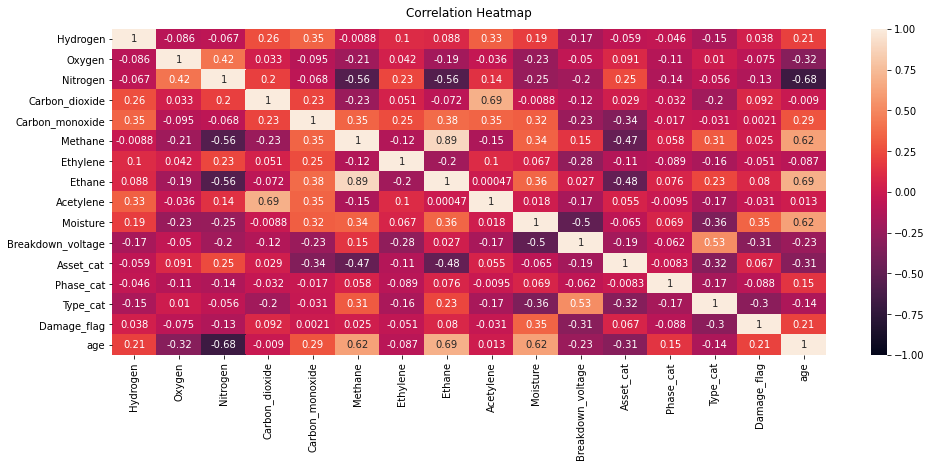

In [ ]:
#Used a seaborn heatmap to check correlation between variables
import seaborn as sns
import matplotlib.pyplot as plt

# Increase the size of the heatmap.
plt.figure(figsize=(16, 6))
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(rawDataCopy.corr(), vmin=-1, vmax=1, annot=True)
# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12);

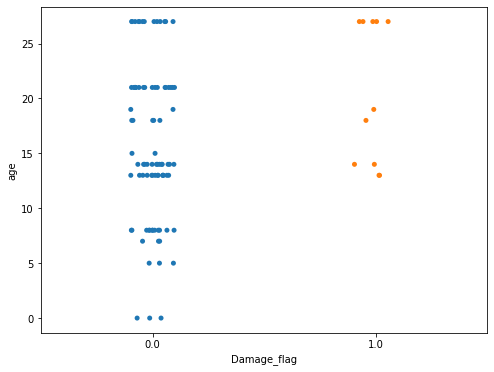

In [ ]:
#Graphs to plot
plt.figure(figsize=(8, 6))
#scatter bar graph of damage flag against age
sns.stripplot(x="Damage_flag", y="age", data=rawDataCopy)

#scatter bar graph of damage flag against breakdown voltage
sns.stripplot(x="Damage_flag", y="Breakdown_voltage", data=rawDataCopy)


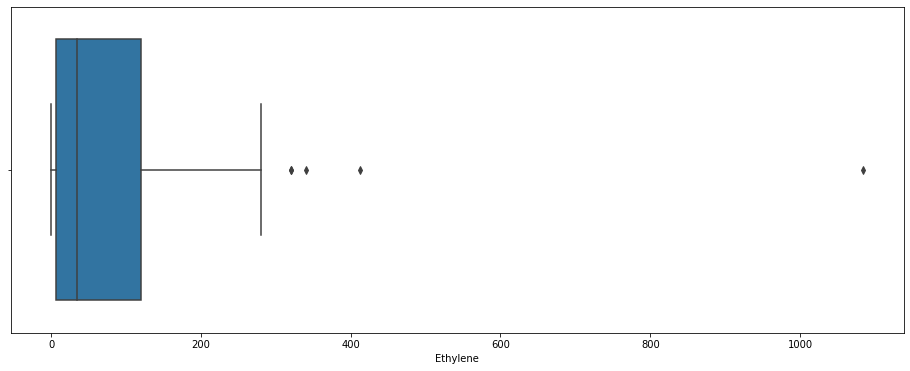

In [ ]:
#Plot boxplots for each column to see outliers
plt.figure(figsize=(16, 6))
sns.boxplot(x=rawDataCopy["Ethylene"])

In [ ]:
#Calculate outliers using the z score and seperate them into their own dataset
from scipy.stats import zscore
import numpy as np

#zscore is a measure of how many standard deviations a data point is from the mean. Omit data if its greater than 3 standard deviations away from the mean
zscores = np.abs(zscore(rawDataCopy))

rawDataCopy2 = rawDataCopy[(zscores < 3).all(axis=1)]
rawDataCopy2.describe()

,Hydrogen,Oxygen,Nitrogen,Carbon_dioxide,Carbon_monoxide,Methane,Ethylene,Ethane,Acetylene,Moisture,Breakdown_voltage,Asset_cat,Phase_cat,Type_cat,Damage_flag,age
count,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000,84.000000
mean,101.677006,22994.834886,70009.131599,966.942107,269.437940,18179.892736,79.618841,352.250462,3.936480,72.950316,40.651786,17.809524,1.190476,1.678571,0.119048,16.357143
std,137.344800,12876.518092,25092.202383,792.725128,149.491538,19961.430700,94.632670,258.021246,8.592058,23.927973,14.822836,10.814399,1.321520,1.537959,0.325790,7.188751
min,0.000000,2400.000000,18000.000000,1.400000,0.600000,3.000000,0.100000,0.100000,0.000000,15.000000,11.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,13.000000,10750.000000,53000.000000,532.000000,163.750000,2784.750000,5.875000,143.250000,0.000000,51.000000,27.750000,8.000000,0.000000,0.000000,0.000000,13.000000
50%,44.000000,24768.500000,72928.500000,786.500000,271.000000,7953.500000,35.000000,283.500000,0.100000,77.000000,40.616667,18.000000,1.000000,2.000000,0.000000,14.000000
75%,138.009783,34819.250000,89412.250000,1258.819565,332.500000,34000.000000,122.000000,572.500000,2.275000,90.000000,53.250000,28.000000,3.000000,3.000000,0.000000,21.000000
max,611.000000,44199.000000,107640.000000,5613.000000,784.000000,79000.000000,412.000000,1100.000000,40.000000,134.000000,79.000000,35.000000,3.000000,5.000000,1.000000,27.000000


In [ ]:
#Initialise DBSCAN 
from sklearn.cluster import KMeans

rawDataCopy2["Clusters"] = KMeans(n_clusters=2).fit_predict(rawDataCopy2)
rawDataCopy2["Clusters"].value_counts()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


1    56
0    28
Name: Clusters, dtype: int64

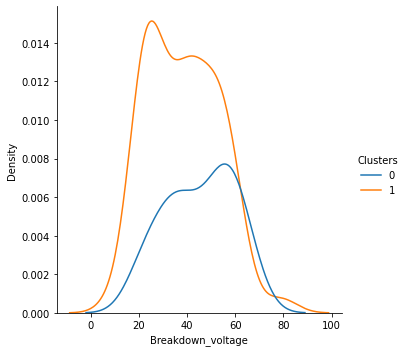

In [ ]:
sns.displot(rawDataCopy2, x="Breakdown_voltage", hue="Clusters", kind="kde")

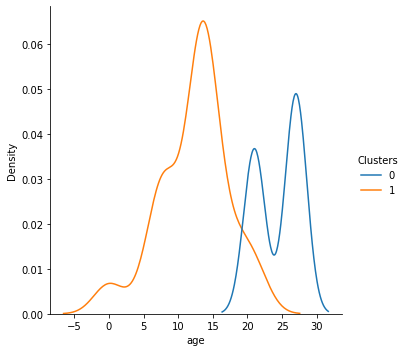

In [ ]:
sns.displot(rawDataCopy2, x="age", hue="Clusters", kind="kde")

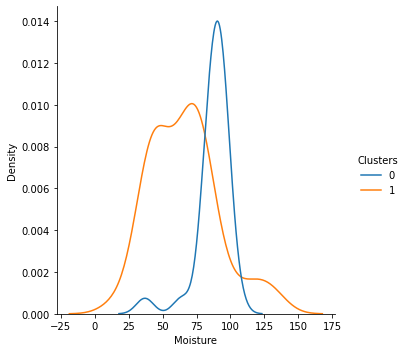

In [ ]:
sns.displot(rawDataCopy2, x="Moisture", hue="Clusters", kind="kde")